## 1. Import depedencies

In [1]:
import os
import re
import string
import functools
import operator 
import json
import time
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from dataclasses import dataclass
from sklearn.metrics import f1_score

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
stopwords = nlp.Defaults.stop_words

D:\workspace\python\amazon-rev-sent-analysis\venv\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


## 2. Data works

In [4]:
ovs = pd.read_csv('data/preprocessed.csv')['overall']

In [16]:
ovs = ovs.value_counts().to_dict()
k = ovs.keys()
v = ovs.values()

<BarContainer object of 5 artists>

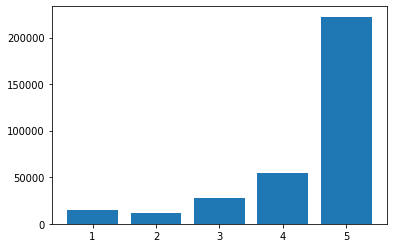

In [21]:
plt.bar(k, v)

In [2]:
class Vocabulary:
    def __init__(self, data):
        self.data = data
        
        self.vocab = {
            '<unk>': 0,
            '<pad>': 1,
            '<sos>': 2,
            '<eos>': 3
        }
        
        self.build_vocab()
        
    def __getitem__(self, index):
        assert type(index) in [str, int], 'Index type must be string or int'
        
        if isinstance(index, str):
            try:
                return self.vocab[index]
            
            except KeyError:
                return self.vocab['<unk>']
        
        elif isinstance(index, int):
            try:
                return list(self.vocab.keys())[list(self.vocab.values()).index(index)]
            except (KeyError,ValueError):
                return self[0]
    
    def __len__(self):
        return len(self.vocab)
    
    def append_word(self, word):
        if not word in self.vocab:
            self.vocab[word] = len(self)
    
    def build_vocab(self):
        bag_of_words = sorted(list(set(self.data)))
        
        for word in bag_of_words:
            self.append_word(word)

In [3]:
class RevDataset(Dataset):
    def __init__(self):
        self.path = 'data/Video_Games_5.json'
        self.prep_path = 'data/preprocessed.csv'
        
        # if preprocessed data already exists - load it
        if os.path.isfile(self.prep_path):
            self.data = pd.read_csv(self.prep_path)[['reviewText', 'overall']]
        
        # else preprocess and save
        else:
            with open(self.path, 'r') as f:
                lines = [json.loads(line.rstrip()) for line in f]
                self.data = pd.DataFrame(lines)[['verified', 'reviewText', 'overall']]
                self.data = self.data[self.data['verified']]

            self.data = self.data.dropna()
            self.data = self.data.reset_index(drop=True)
            self.data = self.data.drop('verified', axis=1)

            self.data['reviewText'] = self.data['reviewText'].apply(self.clean_data)
            self.tok_lemma()

            self.data.to_csv(self.prep_path)
            
        self.build_vocab()
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        assert type(index) == int, 'Index must be int'
        
        item = self.data.iloc[index]
        text = str(item['reviewText']).split()
        
        for i, word in enumerate(text):
            text[i] = self.Voc[word]
            
        return text, item['overall']
    
    @staticmethod
    def clean_data(text):
        if type(text) != str:
            return '   '
        
        # lowercase
        text = text.lower()
        
        # remove \n signs
        text = text.replace('\n\n\n\n', ' ').replace('\n\n\n', ' ').replace('\n\n', ' ').replace('\n', ' ')
        
        # remove url
        text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        
        # remove punctuations
        text = text.translate(str.maketrans('', '', string.punctuation))

        return text 
    
    def tok_lemma(self):
        reviews = self.data['reviewText'].values

        reviews = nlp.pipe(reviews, batch_size=128, n_process=3)

        reviews = [' '.join([word.lemma_ for word in text if not word in stopwords and word.lemma_ and word.text.isalpha()]) for text in reviews]

        self.data['reviewText'] = pd.Series(reviews) 
        
    def build_vocab(self):
        bag_of_words = self.data['reviewText'].apply(lambda x: str(x).split()).tolist()

        bag_of_words = functools.reduce(operator.iconcat, bag_of_words, [])
        
        self.Voc = Vocabulary(bag_of_words)

        self.Voc.build_vocab()

In [4]:
data = RevDataset()
vocab = data.Voc

full_len = len(data)
train_len = int(0.8 * full_len)
test_len = int(0.1 * full_len)
valid_len = full_len - (train_len + test_len)

train_set, test_set, valid_set = random_split(data, [train_len, test_len, valid_len])

del full_len, train_len, test_len, valid_len

In [5]:
@dataclass
class cfg:
    epochs = 20
    max_length = 310
    embed_size = 120
    hidden_size = 512
    num_layers = 3
    heads = 8
    batch_size = 32
    lr = 1.5e-6
    vocab_size = len(vocab)

In [6]:
# lens = [len(data[i][0]) for i in range(len(data)) if len(data[i][0]) < 500]
# plt.figure(figsize=(11, 8))
# sns.histplot(data=lens, bins=15, kde=True)
# plt.show()

In [7]:
def pad_seq(batch):
    reviews = []
    overalls = []
    for i, (text, overall) in enumerate(batch):
        
        text_len = len(text)
        
        if text_len == cfg.max_length:
            pass
        elif text_len > cfg.max_length:
            text = text[:cfg.max_length]
        else:
            pad_len = cfg.max_length - text_len
            for j in range(pad_len):
                # 1 - index of <pad> token in Vocabulary
                text.append(1)
        reviews.append(torch.Tensor(text).type(torch.int64))
        overalls.append(int(overall) - 1)
    
    overalls = torch.LongTensor(overalls)

    return torch.stack(reviews), overalls

In [8]:
train_loader = DataLoader(train_set, batch_size=32, collate_fn=pad_seq, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, collate_fn=pad_seq)
valid_loader = DataLoader(valid_set, batch_size=32, collate_fn=pad_seq)

## 3. Model

Model implementation inspired by Alladin Persson's [movie](https://www.youtube.com/watch?v=U0s0f995w14). [GitHub repo](https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/transformer_from_scratch/transformer_from_scratch.py).

In [9]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        
        assert self.head_dim * heads == embed_size, 'Embed size needs to be divisible by heads'
        
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)
        
    def forward(self, values, keys, queries, mask):
        N = queries.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]
        
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)
        
        values = self.values(values) 
        keys = self.keys(keys)
        queries = self.queries(queries)
        
        energy = torch.einsum('nqhd, nkhd->nhqk', [queries, keys])
        
        if mask is not None:
            # if mask at same point is 0 - shitdown this point - set to -inf, in softmax it will be 0
            energy = energy.masked_fill(mask == 0, -1e20)
            
        attention = torch.softmax(energy / (self.embed_size**(1/2)), dim=3)
        
        # attention shape: N, heads, query_len, key_len
        # values shape: N, value_len, heads, head_dim
        # out shape: N, query_len, heads, head_dim
        out = torch.einsum('nhql, nlhd->nqhd', [attention, values])
        
        out = out.reshape(N, query_len, self.heads*self.head_dim)
        
        return out

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion*embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion*embed_size, embed_size)
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, value, key, queries, mask):
        attention = self.attention(value, key, queries, mask)
        
        x = self.dropout(self.norm1(attention + queries))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        
        return out

In [11]:
class Model(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, max_length, heads, device, forward_expansion, dropout):
        super(Model, self).__init__()
        
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )
        
        self.fc1 = nn.Linear(max_length*embed_size, max_length*forward_expansion)
        self.fc2 = nn.Linear(max_length*forward_expansion, max_length)
        
        self.fc_out = nn.Linear(max_length, 5)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        N, seq_len = x.shape

        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)

        x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        
        for layer in self.layers:
            x = layer(x, x, x, mask)

        # x shape: N, max_length, embed_size
        # flat x
        x = x.reshape(N, -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        
        # out shape: N, 5
        out = torch.softmax(self.fc_out(x), dim=1)
        
        return out 

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
model = Model(
    vocab_size=cfg.vocab_size, 
    embed_size=cfg.embed_size, 
    num_layers=cfg.num_layers, 
    max_length=cfg.max_length,
    heads=cfg.heads, 
    device=device, 
    forward_expansion=4, 
    dropout=0.25)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)
writer = SummaryWriter()

In [15]:
def train_epoch(epoch, loader, model, optimizer, criterion, n_iter):
    running_loss = 0
    corr = 0
    tot_samples = 0 
    
    no_batches = len(loader)
    
    print(f'EPOCH {epoch+1}')
    
    for batch_idx, (source, target) in enumerate(loader):
        source = source.to(device)
        target = target.to(device)
        
        # backward propagation
        scores = model(source)
        loss = criterion(scores, target)

        # forward propagation
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        
        running_loss += loss.item()
        
        _, pred = scores.max(1)

        corr += (pred == target).sum()
        tot_samples += pred.size(0)
        
        if (batch_idx + 1) % int(no_batches * .3) == 0: # .3 - beacouse it should print log ~3 times per epoch
            n_iter += 1
            
            lss = running_loss / tot_samples
            acc = corr / tot_samples
            
            print(f'Epoch: {epoch + 1} Batch: {batch_idx}/{no_batches} Loss: {lss}, Accuracy: {acc}')
            writer.add_scalar('Loss/train', lss, n_iter)
            writer.add_scalar('Accuracy/train', acc, n_iter)

            running_loss = 0
            corr = 0
            tot_samples = 0 
            
    return running_loss, corr, tot_samples, n_iter

In [16]:
def valid_epoch(epoch, loader, model):
    running_loss = 0
    corr = 0
    tot_samples = 0
    
    with torch.no_grad():
        model.eval()
        for batch_idx, (source, target) in enumerate(loader):
            source = source.to(device)
            target = target.to(device)

            scores = model(source)
            loss = criterion(scores, target)
            
            running_loss += loss.item()
        
            _, pred = scores.max(1)

            corr += (pred == target).sum()
            tot_samples += pred.size(0)
            
        model.train()
        
    lss = running_loss / tot_samples
    acc = corr / tot_samples
    
    print(f'Epoch: {epoch + 1} VLoss: {lss}, VAccuracy: {acc}')
    
    writer.add_scalar('Loss/valid', lss, epoch)
    writer.add_scalar('Accuracy/valid', acc, epoch)
    
    return running_loss, corr, tot_samples

In [17]:
model = model.to(device)
SD_PATH = 'models/model-1644595693.1664352.pt'

if os.path.exists(SD_PATH):
    model.load_state_dict(torch.load(SD_PATH, map_location=device))
else:
    n_iter = 0
    vn_iter = 0

    for epoch in range(cfg.epochs):       
        loss, corr, samples, n_iter = train_epoch(epoch, train_loader, model, optimizer, criterion, n_iter)
        val_loss, val_corr, val_samples = valid_epoch(epoch, valid_loader, model)

    torch.save(model.state_dict(), f'models/model-{time.time()}.pt')

In [27]:
predictions = []
true_values = []

with torch.no_grad():
    model.eval()
    for batch_idx, (source, target) in enumerate(test_loader):
        source = source.to(device)
        target = target.to(device)
        
        scores = model(source)
        
        _, pred = scores.max(1)
        
        predictions.extend(pred.tolist())
        true_values.extend(target.tolist())
    
    model.train()

In [32]:
f1_score(true_values, predictions, average='micro')

0.8169624060150376